/var/folders/b8/v9g07hxn7195mcg339r9rgqm0000gn/T/ipykernel_53727/1859297576.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Method'] = df['Method'].apply(lambda x: methods[x])
/var/folders/b8/v9g07hxn7195mcg339r9rgqm0000gn/T/ipykernel_53727/1859297576.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MFU'] = df['Throughput(TFLOPS/s)'] / 312


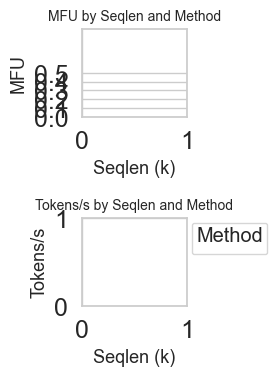

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from convert_csv import add_flops
import logging
import sys

_logger = logging.getLogger(__name__)
_handler = logging.StreamHandler(sys.stdout)
_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
_logger.addHandler(_handler)

methods_order = [
    "Megatron TP",
    "LoongTrain CP",
    "BurstAttention w. DoubleRing",
    "Megatron CP",
    "Deepspeed Ulysses",
    "LoongTrain w. Ulysses(intra node)",
    "BurstAttention w. Ulysses(intra node)",
    "BurstAttention",
]
methods = {
    "Burst-Ring": "BurstAttention w. DoubleRing",
    "Burst-USP": "BurstAttention w. Ulysses(intra node)",
    "megatron-cp": "Megatron CP",
    "Megatron": "Megatron CP",
    "megatron-tp": "Megatron TP",
    "ds-ulysses": "Deepspeed Ulysses",
    "Deepspeed-Ulysses": "Deepspeed Ulysses",
    "burst": "BurstAttention",
    "LoongTrain-Ring": "LoongTrain CP",
    "LoongTrain-USP": "LoongTrain w. Ulysses(intra node)",
}

whole_color_mapping = {
    'BurstAttention w. DoubleRing': '#0077B6',
    'BurstAttention': '#0077B6',
    'BurstAttention w. Ulysses(intra node)': '#E07A5F',
    'Deepspeed Ulysses': '#88B04B',
    'Megatron CP': '#FFA500',
    'Megatron TP': '#FF4500',
    "LoongTrain CP": '#FFD700',
    "LoongTrain w. Ulysses(intra node)": '#FF4500',
}

whole_line_mapping = {
    'BurstAttention w. DoubleRing': "xx",
    'BurstAttention': "\\",
    'BurstAttention w. Ulysses(intra node)': "\\",
    'Deepspeed Ulysses': "",
    'Megatron CP': "//",
    'Megatron TP': 'o',
    "LoongTrain CP": '.',
    "LoongTrain w. Ulysses(intra node)": 'o',
}

label_size = 13

title_size = 10

legend_size = 7

def clean_data(df):
    df = df[df.apply(lambda x: x['Method'] in methods, axis=1)]
    df['Method'] = df['Method'].apply(lambda x: methods[x])
    df['MFU'] = df['Throughput(TFLOPS/s)'] / 312
    return df

def normal_barplot(data, y, hue, ax, palette=None, bar_width=1, hatches={}):
    group_width = 2.0
    space = 0.5

    categories = data[hue].unique()
    categories = sorted(categories, key=lambda x: methods_order.index(x))
    n_categories = len(categories)
    
    # 计算每个组的宽度和偏移量
    bar_width = group_width / n_categories

    # 设置图表的标签和图例
    ax.set_xlabel(hue)  # Corrected x to hue
    ax.set_ylabel(y)
    
    # Plot the bars
    for i, category in enumerate(categories):
        subset = data[data[hue] == category]
        x_positions = np.arange(len(subset)) + i * (bar_width + space)
        bars = sns.barplot(x=x_positions, y=subset[y], width=bar_width, label=category, color=palette[category] if palette else None, ax=ax)

        # Add hatches if specified
        if category in hatches:
            for bar in bars.patches:
                bar.set_hatch(hatches[category])
    
    # Add X for NaN values
    for i, bar in enumerate(ax.patches):
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        if np.isnan(y_value):
            ax.annotate('X', (x_value, 0), textcoords="offset points",
                        xytext=(0,1), ha='center', fontsize=label_size+1, fontweight='bold')

def barplot(data, x, y, hue, ax, palette=None, bar_width=1, hatches={}):
    group_width = 2.0
    space = 0.5

    groups = data[x].unique()
    categories = data[hue].unique()
    disable_groupby=len(groups) == 1
    if disable_groupby:
        return normal_barplot(data, y, hue, ax, palette, bar_width, hatches)
    categories = sorted(categories, key=lambda x: methods_order.index(x))
    n_groups = len(groups)
    n_categories = len(categories)

    # 计算每个组的宽度和偏移量
    bar_width = group_width / n_categories
    group_pos = np.arange(n_groups) * (group_width + space)  # 为每个组添加间隔

    # 为每个类别画条形图
    for i, category in enumerate(categories):
        # 筛选出当前类别的数据
        category_data = data[data[hue] == category]
        # 通过分组平均值来绘图
        if disable_groupby:
            means = category_data[y]
        else:
            means = category_data.groupby(x)[y].mean()
        # 使用偏移量来调整条形位置
        offsets = group_pos + (i * bar_width)
        edge_color = 'black'
        ax.bar(offsets, means, width=bar_width, label=category, align='edge', hatch=hatches.get(category, None), color=palette.get(category, None), edgecolor=edge_color)

    # 设置图表的标签和图例
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xticks(group_pos + (group_width) / 2)
    ax.set_xticklabels(groups)
    for i, bar in enumerate(ax.patches):
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        if np.isnan(y_value):
            ax.annotate('X', (x_value, 0), textcoords="offset points",
                        xytext=(0,1), ha='center', fontsize=label_size+1, fontweight='bold')
    ax.legend(title=hue)

def plot_throughput_and_tokens(df):
    # Convert 'Seqlen(k)' to integer for better grouping
    df['Seqlen(k)'] = df['Seqlen(k)'].astype(int)
    df.sort_values(by='Seqlen(k)', inplace=True)

    # Set the style for the plot
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axs = plt.subplots(2, 1, figsize=(3, 4))

    # Define color and hatch mappings
    color_mapping = {m: whole_color_mapping[m] for m in df['Method'].unique()}
    line_mapping = {m: whole_line_mapping[m] for m in df['Method'].unique()}

    # Plot Throughput
    ax = axs[0]
    barplot(df, 'Seqlen(k)', 'MFU', 'Method', ax, palette=color_mapping, hatches=line_mapping)
    ax.set_title('MFU by Seqlen and Method', fontsize=title_size)
    ax.set_xlabel('Seqlen (k)', fontsize=label_size)
    ax.set_ylabel('MFU', fontsize=label_size)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticks(np.arange(0, 0.6, 0.1))

    # Plot Tokens/s
    ax = axs[1]
    barplot(df, 'Seqlen(k)', 'Tokens/s', 'Method', ax, palette=color_mapping, hatches=line_mapping)
    ax.set_title('Tokens/s by Seqlen and Method', fontsize=title_size)
    ax.set_xlabel('Seqlen (k)', fontsize=label_size)
    ax.set_ylabel('Tokens/s', fontsize=label_size)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1), fontsize=legend_size)

    # Adjust layout
    plt.tight_layout()

# Example usage
def plot_xlsx(model_size, nodes):
    filename = "burst_exp.xlsx"
    sheet = f"{model_size} model {nodes} nodes" 
    logging.info(f"Plotting {sheet} from {filename}")
    try:
        df = pd.read_excel(filename, sheet)
        df = add_flops(df, "Tokens/s")
        df = clean_data(df)
        # df = df[df['Seqlen(k)'] <= 512]
    except Exception as e:
        logging.error(f"Failed to read {sheet} from {filename}")
        logging.error(e)
        return
    plot_throughput_and_tokens(df)
    filename = f"{8 * nodes}x{model_size}.pdf" 
    plt.savefig(filename)
    plt.show()

# plot_xlsx("7b", 1)
plot_xlsx("13b", 4)


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
def avg_mem(mems):
    if mems == "OOM":
        return None,None,None
    mems = mems.split(r"/")
    mems = [float(i) for i in mems]
    avg_m = sum(mems) / len(mems)
    max_m = max(mems)
    min_m = min(mems)
    return avg_m, max_m, min_m
def read_file(name):
    df = pd.read_excel("../burst_exp.xlsx", sheet_name=name)

    original_col = df.columns
    cols = [i.strip() for i in original_col]
    df.columns = cols
    # vpp_size = 1
    # df = df[df['vpp_size'] == vpp_size]
    # drop_method = ['Seq1F1B-avg', 'Seq1F1B-I-avg']
    # df_plot = df[keys_to_keep].copy()
    df_plot = df.copy()
    df_plot = df_plot[df_plot['Method'].apply(lambda x: x not in drop_method)]
    df_plot['avg_memory'] = df_plot['memory_array'].apply(lambda x: avg_mem(x)[0])
    df_plot['max_memory'] = df_plot['memory_array'].apply(lambda x: avg_mem(x)[1])
    df_plot['min_memory'] = df_plot['memory_array'].apply(lambda x: avg_mem(x)[2])
    return df_plot

FileNotFoundError: [Errno 2] No such file or directory: '../burst_exp.xlsx'

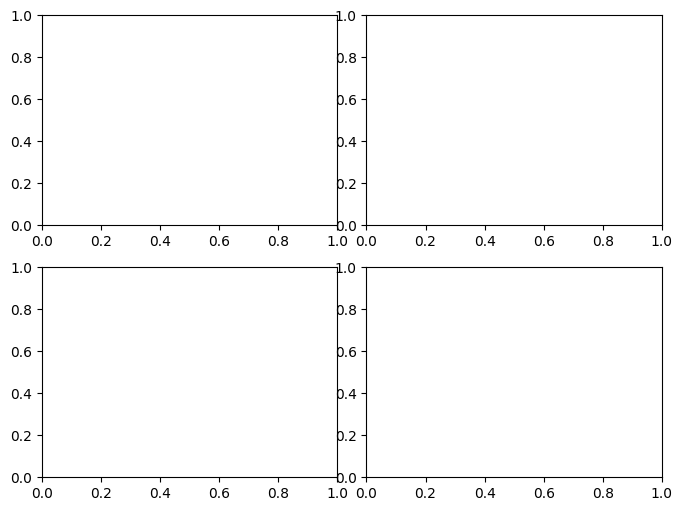

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
tick_fontsize = 23
label_size = 26
title_size = 24
fig_size = (8,6)
legend_alpha = 0.3
import matplotlib.pyplot as plt
import numpy as np

def barplot(data, x, y, hue, ax, palette=None, bar_width=1, hatches={}):
    group_width=2.0
    space=0.5
 
    groups = data[x].unique()
    categories = data[hue].unique()
    n_groups = len(groups)
    n_categories = len(categories)
    
    # 计算每个组的宽度和偏移量
    bar_width = group_width / n_categories
    group_pos = np.arange(n_groups) * (group_width + space)  # 为每个组添加间隔

    # 创建图和轴
    # 为每个类别画条形图
    for i, category in enumerate(categories):
        # 筛选出当前类别的数据
        category_data = data[data[hue] == category]
        # 通过分组平均值来绘图
        means = category_data.groupby(x)[y].mean()
        # 使用偏移量来调整条形位置
        offsets = group_pos + (i * bar_width)
        edge_color = 'black'
        ax.bar(offsets, means, width=bar_width, label=category, align='edge', hatch=hatches.get(category, None), color=palette.get(category, None), edgecolor=edge_color)

        # ax.bar(group_pos + offset, means, width=bar_width / len(categories), color=color, label=category, align='center', hatch=hatches.get(category, None))

    # 设置图表的标签和图例
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'{y} by {x} and {hue}')
    ax.set_xticks(group_pos+(group_width)/2)
    ax.set_xticklabels(groups)
    ax.legend(title=hue)


# 使用示例
# barplot(df, x='Group', y='Values', hue='Category')

    
def plot_mem_train(df, x, y, all_methods, method_name_mapping, color_mapping, file_label, method_col="method", label="", ax=None, line_mapping=None):
    """
    all_methods: list of all methods
    method_mapping: key is the method in the data, value is the method name to show in the plot
    color_mapping: key is the method name to show in the plot, value is the color
    """
    colors = color_mapping
    if ax is not None:
        plt.sca(ax)
    order = all_methods
    for method in all_methods:
        if method not in method_name_mapping:
            df = df[df[method_col] != method]
    for method, new_name in method_name_mapping.items():
        if new_name != method:
            colors[new_name] = colors[method]
            del colors[method]
        df[method_col] = df[method_col].replace(method, new_name)
    df.sort_values(by=[method_col, x], key=lambda x: x.map({method: i for i, method in enumerate(order)}), inplace=True)
    # df['x_str'] = df[x].apply(lambda x: f"x")
    # df[x] = df[x].apply(lambda x: f"  {x//1024}k  ")
    # plt.figure(figsize=fig_size)
    barplot(df, x, y, method_col, ax, palette=colors, hatches=line_mapping)
    # ax = sns.barplot(x=x, y=y, hue=method_col, data=df, palette=colors, errorbar=None, ax=ax)
    # if line_mapping is not None:
    #     hatches = [line_mapping[method] for method in order] * len(df[x].unique())
    #     assert len(hatches) == len(ax.patches)
    #     for patch, hatch in zip(ax.patches, hatches):
    #         patch.set_hatch(hatch)
    #         patch.set_edgecolor('black')

    ax.tick_params(axis='x', labelsize=tick_fontsize)  # 设置X轴刻度大小
    ax.tick_params(axis='y', labelsize=tick_fontsize)  # 设置X轴刻度大小o
    ax.set_yticks(np.arange(0, 51, 25))
    ax.set_xticklabels([f"{l//1024}k" for l in sorted(df[x].unique())])
    ax.set_title(label, fontsize=title_size)
    ax.set(xlabel='', ylabel='')
    ax.legend([],[], frameon=False) 
    # for i, bar in enumerate(ax.patches):
    #     # Find the index of the point
    #     point_index = i % len(df['seqlen'].unique())
    #     # Find the corresponding standard deviation
    #     std = df.iloc[point_index]['std']
    #     # Add error bars
    #     ax.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=std, fmt='none', c='black', capsize=5)
    # plt.rc('legend', fontsize=12, loc='upper left')
    # plt.xlabel('Sequence Length', fontsize=16)
    # plt.ylabel('Memory (GB)', fontsize=16)
    # plt.title(label, fontsize=16)
    # plt.title('LLaMA-2 (7b) Training Memory Usage')
    # def log2_tick_formatter(x, pos):
    #     return f'{2**int(np.log2(x))}' if x > 0 else '1'
    # ax.set_xscale('log', base=2)
    # log2_formatter = FuncFormatter(log2_tick_formatter)
    # ax.xaxis.set_major_formatter(log2_formatter)
    # plt.legend(framealpha=legend_alpha)
    for i, bar in enumerate(ax.patches):
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        if np.isnan(y_value):
            ax.annotate('X', (x_value, 1), textcoords="offset points",
                        xytext=(0,1), ha='center', fontsize=22, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f"./picture/{file_label}_memory.svg")
    # plt.show()
methods = ['1F1B', '1F1B-I', 'Seq1F1B', 'Seq1F1B-I', ]
name_mapping = {
    'Seq1F1B': 'Seq1F1B',
    'Seq1F1B-I': 'Seq1F1B-I',
    '1F1B': '1F1B',
    '1F1B-I': '1F1B-I',
}
color_mapping = {
    'Seq1F1B': '#FFFFFF',
    'Seq1F1B-I': '#B0A8B9',
    '1F1B': '#B0A8B9',
    '1F1B-I': '#4B4453',
}
line_mapping = {
    'Seq1F1B': "//",
    'Seq1F1B-I': "\\",
    '1F1B': "",
    '1F1B-I': "",
}
name = ['8x2.7b' ,'32x7b zhihu','32x13b zhihu','64x30b zhihu']
labels = ["2.7B Model, 8GPUs", "7B Model, 32GPUs", "13B Model, 32GPUs", "30B Model, 64GPUs"]
fig, axs = plt.subplots(2,2, figsize=fig_size)  # figsize可以根据需要调整
plt.subplots_adjust(wspace=0.1)  # 调整子图之间的


file_labels = ["30bx32A100", "7bx32A100", "13bx32A100", "2.7bx8A100"]
for i in range(len(name)):
    ax = axs[i//2, i%2]
    # ax = axs[i]
    file_label = file_labels[i]
    n = name[i]
    label = labels[i]
    df_plot = read_file(n)
    df_plot['seq_length'] = df_plot['seq_length'].apply(lambda x: int(x))
    df_plot.sort_values(by='seq_length', inplace=True)
    plot_mem_train(df_plot,"seq_length",'max_memory', methods, name_mapping, color_mapping, file_label, method_col="Method", label=label, ax=ax, line_mapping=line_mapping)
xlabel = "Sequence Length"
ylabel = "Memory (GB)"
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), title='',ncol=4, fontsize=20, columnspacing=0.8)

fig.text(0.5, -0.05, xlabel, ha='center',fontdict={'size': label_size})
fig.text(-0.02, 0.5, ylabel, va='center', rotation='vertical', fontdict={'size': label_size})
plt.tight_layout()
plt.savefig(f"./picture/seq1f1b_memory_single_column.pdf",bbox_inches = 'tight',dpi=500)
plt.savefig(f"./picture/seq1f1b_memory._single_column.png",bbox_inches = 'tight',dpi=500)
plt.show()